# HOUSE SALE PRICE ESTIMATOR - GROUP 23

### 1. Install pyspark and required modules

In [0]:
!pip install pyspark
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

Requirement already satisfied: pyspark in /databricks/python3/lib/python3.8/site-packages (3.2.1)
Requirement already satisfied: py4j==0.10.9.3 in /databricks/python3/lib/python3.8/site-packages (from pyspark) (0.10.9.3)
 WARNING: You are using pip version 21.0.1; however, version 22.0.3 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (1.19.2)
 WARNING: You are using pip version 21.0.1; however, version 22.0.3 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (1.2.4)
Requirement already satisfied: pytz>=2017.3 in /databricks/python3/lib/python3.8/site-packages (from pandas) (2020.5)
Requirement already satisfied: numpy>=1.16.5 in /databricks/python3/lib/python3.8/site-packages (from pandas) (1.19.2)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas) (2.8.1)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.8/site-packages (from python-dateutil>=2.7.3->pandas) (1.15.0)
 WARNING: You are using pip version 21.0.1; however, version 22.0.3 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (3.4.2)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib) (1.3.1)
Requirement already satisfied: numpy>=1.16 in /databricks/python3/lib/python3.8/site-packages (from matplotlib) (1.19.2)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib) (0.10.0)
Requirement already satisfied: pillow>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib) (8.2.0)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib) (2.4.7)
Requirement already satisfied: python-dateutil>=2.7 in /databricks/python3/lib/python3.8/site-packages (from matplotlib) (2.8.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib) (1.15.0)
 WARNING: You are using pip version 21.0.1; however, version 22.0.3 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.8/site-packages (0.11.1)
Requirement already satisfied: pandas>=0.23 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (1.2.4)
Requirement already satisfied: matplotlib>=2.2 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (3.4.2)
Requirement already satisfied: scipy>=1.0 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (1.6.2)
Requirement already satisfied: numpy>=1.15 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (1.19.2)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.2->seaborn) (1.3.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.2->seaborn) (0.10.0)
Requirement already satisfied: pillow>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.2->seaborn) (8.2.0)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.2->seaborn) (2.4.7)
Requirement already satisfied: python-dateutil>=2.7 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.2->seaborn) (2.8.1)
Requirement already satisfied: six in /dat

### 2. Initialize Spark and other required modules

In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, VectorIndexer, Bucketizer, OneHotEncoder, MinMaxScaler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GeneralizedLinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col,isnan,when,count
import datetime

### 3. Creating Spark Session

In [0]:
spark = SparkSession.builder.getOrCreate()
spark

Out[74]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.239.254.104:7077 
 AppName 
 Databricks Shell

### 4. Load Data

In [0]:
# Train data
df_train = spark.read.csv('/FileStore/tables/house_sales_train.csv', inferSchema=True, header=True)

# Test data
df_test = spark.read.csv('/FileStore/tables/house_sales_test.csv', inferSchema=True, header=True)

# Sample Submission
df_sample_submission = spark.read.csv('/FileStore/tables/sample_submission.csv', inferSchema=True, header=True)

# Columns to be part of Submission
col_sample_submission = ['Id','SalePrice']
# df_train.cache()

* There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative, 43 categorical in addition to Id and SalePrice.

* Quantitative
1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

* Qualitative
Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities,

### 5. Exploratory Data Analysis

In [0]:
# Schema of Train data
df_train.printSchema()

root
-- Id: integer (nullable = true)
-- MSSubClass: integer (nullable = true)
-- MSZoning: string (nullable = true)
-- LotFrontage: string (nullable = true)
-- LotArea: integer (nullable = true)
-- Street: string (nullable = true)
-- Alley: string (nullable = true)
-- LotShape: string (nullable = true)
-- LandContour: string (nullable = true)
-- Utilities: string (nullable = true)
-- LotConfig: string (nullable = true)
-- LandSlope: string (nullable = true)
-- Neighborhood: string (nullable = true)
-- Condition1: string (nullable = true)
-- Condition2: string (nullable = true)
-- BldgType: string (nullable = true)
-- HouseStyle: string (nullable = true)
-- OverallQual: integer (nullable = true)
-- OverallCond: integer (nullable = true)
-- YearBuilt: integer (nullable = true)
-- YearRemodAdd: integer (nullable = true)
-- RoofStyle: string (nullable = true)
-- RoofMatl: string (nullable = true)
-- Exterior1st: string (nullable = true)
-- Exterior2nd: string (nullable = true)
-- MasVnrType: string (nullable = true)
-- MasVnrArea: string (nullable = true)
-- ExterQual: string (nullable = true)
-- ExterCond: string (nullable = true)
-- Foundation: string (nullable = true)
-- BsmtQual: string (nullable = true)
-- BsmtCond: string (nullable = true)
-- BsmtExposure: string (nullable = true)
-- BsmtFinType1: string (nullable = true)
-- BsmtFinSF1: integer (nullable = true)
-- BsmtFinType2: string (nullable = true)
-- BsmtFinSF2: integer (nullable = true)
-- BsmtUnfSF: integer (nullable = true)
-- TotalBsmtSF: integer (nullable = true)
-- Heating: string (nullable = true)
-- HeatingQC: string (nullable = true)
-- CentralAir: string (nullable = true)
-- Electrical: string (nullable = true)
-- 1stFlrSF: integer (nullable = true)
-- 2ndFlrSF: integer (nullable = true)
-- LowQualFinSF: integer (nullable = true)
-- GrLivArea: integer (nullable = true)
-- BsmtFullBath: integer (nullable = true)
-- BsmtHalfBath: integer (nullable = true)
-- FullBath: integer (nullable = true)
-- HalfBath: integer (nullable = true)
-- BedroomAbvGr: integer (nullable = true)
-- KitchenAbvGr: integer (nullable = true)
-- KitchenQual: string (nullable = true)
-- TotRmsAbvGrd: integer (nullable = true)
-- Functional: string (nullable = true)
-- Fireplaces: integer (nullable = true)
-- FireplaceQu: string (nullable = true)
-- GarageType: string (nullable = true)
-- GarageYrBlt: string (nullable = true)
-- GarageFinish: string (nullable = true)
-- GarageCars: integer (nullable = true)
-- GarageArea: integer (nullable = true)
-- GarageQual: string (nullable = true)
-- GarageCond: string (nullable = true)
-- PavedDrive: string (nullable = true)
-- WoodDeckSF: integer (nullable = true)
-- OpenPorchSF: integer (nullable = true)
-- EnclosedPorch: integer (nullable = true)
-- 3SsnPorch: integer (nullable = true)
-- ScreenPorch: integer (nullable = true)
-- PoolArea: integer (nullable = true)
-- PoolQC: string (nullable = true)
-- Fence: string (nullable = true)
-- MiscFeature: string (nullable = true)
-- MiscVal: integer (nullable = true)
-- MoSold: integer (nullable = true)
-- YrSold: integer (nullable = true)
-- SaleType: string (nullable = true)
-- SaleCondition: string (nullable = true)
-- SalePrice: integer (nullable = true)

In [0]:
# Schema of Test data
df_test.printSchema()

root
-- Id: integer (nullable = true)
-- MSSubClass: integer (nullable = true)
-- MSZoning: string (nullable = true)
-- LotFrontage: string (nullable = true)
-- LotArea: integer (nullable = true)
-- Street: string (nullable = true)
-- Alley: string (nullable = true)
-- LotShape: string (nullable = true)
-- LandContour: string (nullable = true)
-- Utilities: string (nullable = true)
-- LotConfig: string (nullable = true)
-- LandSlope: string (nullable = true)
-- Neighborhood: string (nullable = true)
-- Condition1: string (nullable = true)
-- Condition2: string (nullable = true)
-- BldgType: string (nullable = true)
-- HouseStyle: string (nullable = true)
-- OverallQual: integer (nullable = true)
-- OverallCond: integer (nullable = true)
-- YearBuilt: integer (nullable = true)
-- YearRemodAdd: integer (nullable = true)
-- RoofStyle: string (nullable = true)
-- RoofMatl: string (nullable = true)
-- Exterior1st: string (nullable = true)
-- Exterior2nd: string (nullable = true)
-- MasVnrType: string (nullable = true)
-- MasVnrArea: string (nullable = true)
-- ExterQual: string (nullable = true)
-- ExterCond: string (nullable = true)
-- Foundation: string (nullable = true)
-- BsmtQual: string (nullable = true)
-- BsmtCond: string (nullable = true)
-- BsmtExposure: string (nullable = true)
-- BsmtFinType1: string (nullable = true)
-- BsmtFinSF1: string (nullable = true)
-- BsmtFinType2: string (nullable = true)
-- BsmtFinSF2: string (nullable = true)
-- BsmtUnfSF: string (nullable = true)
-- TotalBsmtSF: string (nullable = true)
-- Heating: string (nullable = true)
-- HeatingQC: string (nullable = true)
-- CentralAir: string (nullable = true)
-- Electrical: string (nullable = true)
-- 1stFlrSF: integer (nullable = true)
-- 2ndFlrSF: integer (nullable = true)
-- LowQualFinSF: integer (nullable = true)
-- GrLivArea: integer (nullable = true)
-- BsmtFullBath: string (nullable = true)
-- BsmtHalfBath: string (nullable = true)
-- FullBath: integer (nullable = true)
-- HalfBath: integer (nullable = true)
-- BedroomAbvGr: integer (nullable = true)
-- KitchenAbvGr: integer (nullable = true)
-- KitchenQual: string (nullable = true)
-- TotRmsAbvGrd: integer (nullable = true)
-- Functional: string (nullable = true)
-- Fireplaces: integer (nullable = true)
-- FireplaceQu: string (nullable = true)
-- GarageType: string (nullable = true)
-- GarageYrBlt: string (nullable = true)
-- GarageFinish: string (nullable = true)
-- GarageCars: string (nullable = true)
-- GarageArea: string (nullable = true)
-- GarageQual: string (nullable = true)
-- GarageCond: string (nullable = true)
-- PavedDrive: string (nullable = true)
-- WoodDeckSF: integer (nullable = true)
-- OpenPorchSF: integer (nullable = true)
-- EnclosedPorch: integer (nullable = true)
-- 3SsnPorch: integer (nullable = true)
-- ScreenPorch: integer (nullable = true)
-- PoolArea: integer (nullable = true)
-- PoolQC: string (nullable = true)
-- Fence: string (nullable = true)
-- MiscFeature: string (nullable = true)
-- MiscVal: integer (nullable = true)
-- MoSold: integer (nullable = true)
-- YrSold: integer (nullable = true)
-- SaleType: string (nullable = true)
-- SaleCondition: string (nullable = true)

* We observe there is discrepancy in the datatypes of the dataframe for train and test dataset
* Few integer columns in test dataset have NA, None values due to which the type is inferred as string by pyspark
* The datatype of few columns of test dataset need to be modified from string to int type

In [0]:
# Train Data Description
df_train.summary().toPandas().head()

Out[78]:

,summary,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
1,mean,730.5,56.897260273972606,None,70.04995836802665,10516.828082191782,None,None,None,None,None,None,None,None,None,None,None,None,6.0993150684931505,5.575342465753424,1971.267808219178,1984.8657534246574,None,None,None,None,None,103.68526170798899,None,None,None,None,None,None,None,443.6397260273973,None,46.54931506849315,567.2404109589041,1057.4294520547944,...,None,None,1162.626712328767,346.99246575342465,5.844520547945206,1515.463698630137,0.42534246575342466,0.057534246575342465,1.5650684931506849,0.38287671232876713,2.8664383561643834,1.0465753424657533,None,6.517808219178082,None,0.613013698630137,None,None,1978.5061638868744,None,1.7671232876712328,472.9801369863014,None,None,None,94.2445205479452,46.66027397260274,21.954109589041096,3.4095890410958902,15.060958904109588,2.758904109589041,None,None,None,43.489041095890414,6.321917808219178,2007.8157534246575,None,None,180921.19589041095
2,stddev,421.6100093688479,42.30057099381045,None,24.28475177448321,9981.26493237915,None,None,None,None,None,None,None,None,None,None,None,None,1.3829965467415926,1.1127993367127318,30.202904042525294,20.64540680770938,None,None,None,None,None,181.06620658721647,None,None,None,None,None,None,None,456.0980908409278,None,161.3192728065416,441.8669552924343,438.7053244594709,...,None,None,386.5877380410744,436.528435886257,48.62308143352024,525.4803834232024,0.5189106060898061,0.23875264627921197,0.5509158012954318,0.5028853810928912,0.8157780441442279,0.22033819838403076,None,1.6253932905840511,None,0.6446663863122297,None,None,24.68972476859027,None,0.7473150101111095,213.8048414533803,None,None,None,125.33879435172422,66.2560276766497,61.11914860172857,29.317330556781872,55.75741528187416,40.17730694453021,None,None,None,496.1230244579441,2.7036262083595113,1.3280951205521145,None,None,79442.50288288663
3,min,1,20,C (all),100,1300,Grvl,Grvl,IR1,Bnk,AllPub,Corner,Gtl,Blmngtn,Artery,Artery,1Fam,1.5Fin,1,1,1872,1950,Flat,ClyTile,AsbShng,AsbShng,BrkCmn,0,Ex,Ex,BrkTil,Ex,Fa,Av,ALQ,0,ALQ,0,0,0,...,N,FuseA,334,0,0,334,0,0,0,0,0,0,Ex,2,Maj1,0,Ex,2Types,1900,Fin,0,0,Ex,Ex,N,0,0,0,0,0,0,Ex,GdPrv,Gar2,0,1,2006,COD,Abnorml,34900
4,25%,365,20,None,59.0,7540,None,None,None,None,None,None,None,None,None,None,None,None,5,5,1954,1967,None,None,None,None,None,0.0,None,None,None,None,None,None,None,0,None,0,223,795,...,None,None,882,0,0,1128,0,0,1,0,2,1,None,5,None,0,None,None,1961.0,None,1,330,None,None,None,0,0,0,0,0,0,None,None,None,0,5,2007,None,None,129900


In [0]:
# Test Data Description
df_test.summary().toPandas().head()

Out[79]:

,summary,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,count,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,...,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459
1,mean,2190.0,57.37834132967786,None,68.58035714285714,9819.161069225496,None,None,None,None,None,None,None,None,None,None,None,None,6.078821110349555,5.5538039753255655,1971.357779300891,1983.6627827278958,None,None,None,None,None,100.70914127423822,None,None,None,None,None,None,None,439.2037037037037,None,52.61934156378601,554.2949245541838,1046.1179698216736,...,None,None,None,1156.534612748458,325.96778615490064,3.5435229609321452,1486.0459218642907,0.4344543582704187,0.06520247083047358,1.570938999314599,0.3776559287183002,2.8540095956134337,1.0424948594928032,None,6.385195339273475,None,0.5812200137080192,None,None,1977.7212165097756,None,1.7661179698216736,472.76886145404666,None,None,None,93.17477724468814,48.3139136394791,24.24331734064428,1.794379712131597,17.064427690198766,1.7443454420836189,None,None,None,58.16792323509253,6.104180945853324,2007.7697052775875,None,None
2,stddev,421.32133421732476,42.746879618718204,None,22.37684128077513,4955.517326926451,None,None,None,None,None,None,None,None,None,None,None,None,1.4368116404730202,1.1137396032892082,30.39007083720532,21.13046690817052,None,None,None,None,None,177.62590010361586,None,None,None,None,None,None,None,455.2680419797152,None,176.75392612672954,437.26048581127924,442.89862416784206,...,None,None,None,398.16581959237874,420.61022646910345,44.043250864375544,485.5660986532532,0.5306475357080623,0.2524682621647408,0.5551898880356613,0.5030166769415861,0.8297883627354514,0.20847167211324952,None,1.5088945751925396,None,0.6474204530720105,None,None,26.431174889801383,None,0.7759450711253343,217.0486111278434,None,None,None,127.744881519076,68.88336411315396,67.22776541956965,20.207841751496485,56.609762906910554,30.491646305342048,None,None,None,630.8069775897081,2.722431901250807,1.3017401493804113,None,None
3,min,1461,20,C (all),100,1470,Grvl,Grvl,IR1,Bnk,AllPub,Corner,Gtl,Blmngtn,Artery,Artery,1Fam,1.5Fin,1,1,1879,1950,Flat,CompShg,AsbShng,AsbShng,BrkCmn,0,Ex,Ex,BrkTil,Ex,Fa,Av,ALQ,0,ALQ,0,0,0,...,Ex,N,FuseA,407,0,0,407,0,0,0,0,0,0,Ex,3,Maj1,0,Ex,2Types,1895,Fin,0,0,Fa,Ex,N,0,0,0,0,0,0,Ex,GdPrv,Gar2,0,1,2006,COD,Abnorml
4,25%,1825,20,None,58.0,7390,None,None,None,None,None,None,None,None,None,None,None,None,5,5,1953,1963,None,None,None,None,None,0.0,None,None,None,None,None,None,None,0.0,None,0.0,219.0,784.0,...,None,None,None,873,0,0,1117,0.0,0.0,1,0,2,1,None,5,None,0,None,None,1959.0,None,1.0,318.0,None,None,None,0,0,0,0,0,0,None,None,None,0,4,2007,None,None


* We observe compared to remaining column values , the values for columns GarageYrBlt, GrLivArea, 1stFlrSF, TotalBsmtSF ,YearBuilt ,YearRemodAdd and LotArea are higher. These columns need to be scaled appropriately

### 6. Data Cleaning and Transformation

In [0]:
# Modifying datatype for few columns of Test dataset
def cast_to_int(_sdf: DataFrame,col_list: list) -> DataFrame:
    for col in col_list:
        _sdf = _sdf.withColumn(col, _sdf[col].cast('int'))
    return _sdf

features_to_be_modified = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea','BsmtFullBath', 'BsmtHalfBath']
df_test_typecast = cast_to_int(df_test, features_to_be_modified)

#### 6.1 Find count for empty, None, Null, Nan with string literals.

In [0]:
df_train.select([count(when(col(c).contains('None'), c )).alias(c) for c in df_train.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 864 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0 
 SalePrice | 0

In [0]:
df_train.select([count(when(col(c).contains('NULL'), c )).alias(c) for c in df_train.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 0 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0 
 SalePrice | 0

In [0]:
df_train.select([count(when(col(c) == '', c )).alias(c) for c in df_train.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 0 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0 
 SalePrice | 0

In [0]:
df_train.select([count(when(col(c).isNull(), c )).alias(c) for c in df_train.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 0 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0 
 SalePrice | 0

In [0]:
df_train.select([count(when(isnan(c), c )).alias(c) for c in df_train.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 0 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0 
 SalePrice | 0

In [0]:
df_train.select([count(when(isnan(c), c )).alias(c) for c in df_train.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 0 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0 
 SalePrice | 0

In [0]:
df_test.select([count(when(isnan(c), c )).alias(c) for c in df_test.columns]).show(truncate=False, vertical=True)

-RECORD 0------------
 Id | 0 
 MSSubClass | 0 
 MSZoning | 0 
 LotFrontage | 0 
 LotArea | 0 
 Street | 0 
 Alley | 0 
 LotShape | 0 
 LandContour | 0 
 Utilities | 0 
 LotConfig | 0 
 LandSlope | 0 
 Neighborhood | 0 
 Condition1 | 0 
 Condition2 | 0 
 BldgType | 0 
 HouseStyle | 0 
 OverallQual | 0 
 OverallCond | 0 
 YearBuilt | 0 
 YearRemodAdd | 0 
 RoofStyle | 0 
 RoofMatl | 0 
 Exterior1st | 0 
 Exterior2nd | 0 
 MasVnrType | 0 
 MasVnrArea | 0 
 ExterQual | 0 
 ExterCond | 0 
 Foundation | 0 
 BsmtQual | 0 
 BsmtCond | 0 
 BsmtExposure | 0 
 BsmtFinType1 | 0 
 BsmtFinSF1 | 0 
 BsmtFinType2 | 0 
 BsmtFinSF2 | 0 
 BsmtUnfSF | 0 
 TotalBsmtSF | 0 
 Heating | 0 
 HeatingQC | 0 
 CentralAir | 0 
 Electrical | 0 
 1stFlrSF | 0 
 2ndFlrSF | 0 
 LowQualFinSF | 0 
 GrLivArea | 0 
 BsmtFullBath | 0 
 BsmtHalfBath | 0 
 FullBath | 0 
 HalfBath | 0 
 BedroomAbvGr | 0 
 KitchenAbvGr | 0 
 KitchenQual | 0 
 TotRmsAbvGrd | 0 
 Functional | 0 
 Fireplaces | 0 
 FireplaceQu | 0 
 GarageType | 0 
 GarageYrBlt | 0 
 GarageFinish | 0 
 GarageCars | 0 
 GarageArea | 0 
 GarageQual | 0 
 GarageCond | 0 
 PavedDrive | 0 
 WoodDeckSF | 0 
 OpenPorchSF | 0 
 EnclosedPorch | 0 
 3SsnPorch | 0 
 ScreenPorch | 0 
 PoolArea | 0 
 PoolQC | 0 
 Fence | 0 
 MiscFeature | 0 
 MiscVal | 0 
 MoSold | 0 
 YrSold | 0 
 SaleType | 0 
 SaleCondition | 0

As can be seen about except for *MasVnrType* there are no columns where are empty or missing records. There are no nan records as well.

In [0]:
df_train.select( "LotFrontage" ).distinct().collect()

Out[88]: [Row(LotFrontage='51'),
 Row(LotFrontage='124'),
 Row(LotFrontage='54'),
 Row(LotFrontage='101'),
 Row(LotFrontage='138'),
 Row(LotFrontage='69'),
 Row(LotFrontage='112'),
 Row(LotFrontage='42'),
 Row(LotFrontage='73'),
 Row(LotFrontage='87'),
 Row(LotFrontage='64'),
 Row(LotFrontage='30'),
 Row(LotFrontage='34'),
 Row(LotFrontage='59'),
 Row(LotFrontage='160'),
 Row(LotFrontage='85'),
 Row(LotFrontage='52'),
 Row(LotFrontage='35'),
 Row(LotFrontage='NA'),
 Row(LotFrontage='71'),
 Row(LotFrontage='98'),
 Row(LotFrontage='47'),
 Row(LotFrontage='99'),
 Row(LotFrontage='110'),
 Row(LotFrontage='107'),
 Row(LotFrontage='96'),
 Row(LotFrontage='43'),
 Row(LotFrontage='100'),
 Row(LotFrontage='70'),
 Row(LotFrontage='174'),
 Row(LotFrontage='168'),
 Row(LotFrontage='61'),
 Row(LotFrontage='75'),
 Row(LotFrontage='140'),
 Row(LotFrontage='120'),
 Row(LotFrontage='46'),
 Row(LotFrontage='130'),
 Row(LotFrontage='78'),
 Row(LotFrontage='89'),
 Row(LotFrontage='77'),
 Row(LotFrontage='118'),
 Row(LotFrontage='68'),
 Row(LotFrontage='60'),
 Row(LotFrontage='90'),
 Row(LotFrontage='104'),
 Row(LotFrontage='41'),
 Row(LotFrontage='128'),
 Row(LotFrontage='102'),
 Row(LotFrontage='55'),
 Row(LotFrontage='111'),
 Row(LotFrontage='95'),
 Row(LotFrontage='93'),
 Row(LotFrontage='40'),
 Row(LotFrontage='103'),
 Row(LotFrontage='38'),
 Row(LotFrontage='44'),
 Row(LotFrontage='144'),
 Row(LotFrontage='115'),
 Row(LotFrontage='82'),
 Row(LotFrontage='53'),
 Row(LotFrontage='92'),
 Row(LotFrontage='122'),
 Row(LotFrontage='108'),
 Row(LotFrontage='86'),
 Row(LotFrontage='58'),
 Row(LotFrontage='81'),
 Row(LotFrontage='33'),
 Row(LotFrontage='114'),
 Row(LotFrontage='150'),
 Row(LotFrontage='48'),
 Row(LotFrontage='153'),
 Row(LotFrontage='141'),
 Row(LotFrontage='97'),
 Row(LotFrontage='67'),
 Row(LotFrontage='106'),
 Row(LotFrontage='84'),
 Row(LotFrontage='79'),
 Row(LotFrontage='24'),
 Row(LotFrontage='313'),
 Row(LotFrontage='32'),
 Row(LotFrontage='116'),
 Row(LotFrontage='152'),
 Row(LotFrontage='88'),
 Row(LotFrontage='134'),
 Row(LotFrontage='149'),
 Row(LotFrontage='105'),
 Row(LotFrontage='56'),
 Row(LotFrontage='36'),
 Row(LotFrontage='37'),
 Row(LotFrontage='49'),
 Row(LotFrontage='63'),
 Row(LotFrontage='65'),
 Row(LotFrontage='121'),
 Row(LotFrontage='39'),
 Row(LotFrontage='62'),
 Row(LotFrontage='83'),
 Row(LotFrontage='109'),
 Row(LotFrontage='21'),
 Row(LotFrontage='182'),
 Row(LotFrontage='66'),
 Row(LotFrontage='91'),
 Row(LotFrontage='94'),
 Row(LotFrontage='72'),
 Row(LotFrontage='74'),
 Row(LotFrontage='137'),
 Row(LotFrontage='129'),
 Row(LotFrontage='76'),
 Row(LotFrontage='80'),
 Row(LotFrontage='50'),
 Row(LotFrontage='57'),
 Row(LotFrontage='45')]

In [0]:
# Get Integer and String features of Train Dataset
def get_features (df_train):
    str_features = [] 
    int_features = []
    for col in  df_train.dtypes:
        if col[0] not in ('Id'):
            if col[1] == 'string':
                str_features += [col[0]]
            else:
                int_features += [col[0]]
    return str_features, int_features


In [0]:
print("Train Dataset :\n")

str_features, int_features = get_features (df_train)
print(f'str_features : {str_features}', "\n")
print(f'int_features: {int_features}')

Train Dataset :

str_features : ['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

int_features: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [0]:
print("Typecasted Test Dataset :\n")

str_features, int_features = get_features (df_test_typecast)
print(f'str_features : {str_features}', "\n")
print(f'int_features: {int_features}')

Typecasted Test Dataset :

str_features : ['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

int_features: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

* We observe the dataypes of all the columns of train dataset and typecasted test dataset match perfectly

In [0]:
df_test_typecast.select(int_features).limit(5).toPandas().T

Out[92]:

,0,1,2,3,4
MSSubClass,20,20,60,60,120
LotArea,11622,14267,13830,9978,5005
OverallQual,5,6,5,6,8
OverallCond,6,6,5,6,5
YearBuilt,1961,1958,1997,1998,1992
YearRemodAdd,1961,1958,1998,1998,1992
BsmtFinSF1,468,923,791,602,263
BsmtFinSF2,144,0,0,0,0
BsmtUnfSF,270,406,137,324,1017
TotalBsmtSF,882,1329,928,926,1280


#### 6.2 Covariance Analysis

In [0]:
saleprice_cov = {} 
for col in  df_train.dtypes:
    if col[0] != 'SalePrice' and col[1] != 'string':
        saleprice_cov[col[0]] = df_train.cov('SalePrice', col[0])

dict(sorted(saleprice_cov.items(), key=lambda item: item[1], reverse= True))

Out[93]: {'LotArea': 209211069.9363728,
 'GrLivArea': 29581866.743236583,
 'TotalBsmtSF': 21384416.734185517,
 '1stFlrSF': 18606627.851789113,
 'BsmtFinSF1': 14001370.60454995,
 '2ndFlrSF': 11074148.695788065,
 'GarageArea': 10589102.52274217,
 'BsmtUnfSF': 7528863.6602073265,
 'WoodDeckSF': 3230258.4818828786,
 'OpenPorchSF': 1662523.3606316943,
 'YearBuilt': 1254636.8755358825,
 'YearRemodAdd': 831707.8529091986,
 'ScreenPorch': 493653.54802313424,
 'PoolArea': 294932.3392415523,
 '3SsnPorch': 103837.23430948195,
 'OverallQual': 86904.12583679946,
 'TotRmsAbvGrd': 68917.16854479058,
 'GarageCars': 38020.18135897172,
 'FullBath': 24538.08320110413,
 'Fireplaces': 23913.252006910352,
 'HalfBath': 11350.236118752762,
 'BedroomAbvGr': 10901.465523392808,
 'MoSold': 9972.849164843636,
 'BsmtFullBath': 9362.786396199308,
 'BsmtHalfBath': -319.48489019500977,
 'KitchenAbvGr': -2378.952241636698,
 'YrSold': -3051.540990733885,
 'OverallCond': -6882.738552395615,
 'LowQualFinSF': -98909.80434055999,
 'BsmtFinSF2': -145817.53057169958,
 'MSSubClass': -283233.7372285389,
 'EnclosedPorch': -624304.8923066083,
 'Id': -734073.2179575008,
 'MiscVal': -835150.301484408}

#### 6.3 Correlation Analysis

In [0]:
corr = df_train.toPandas().corr()
corr[['SalePrice']].sort_values(by='SalePrice',ascending=False).style.background_gradient(cmap='viridis', axis=None)

Out[94]:

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


* We can see that OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF ,1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd, Fireplaces, BsmtFinSF1, WoodDeckSF, 2ndFlrSF, OpenPorchSF, HalfBath, LotArea, BsmtFinSF1 are the top influencers of the Sale Price

* We can obseve the columns BedroomAbvGr, ScreenPorch, PoolArea, MoSold, 3SsnPorch BsmtFinSF2, BsmtHalfBath , MiscVal , LowQualFinSF, YrSold, OverallCond, MSSubClass, EnclosedPorch do not impact the Sale Price

### 7. Dropping Low Influencing Columns (Feature Selection)

In [0]:
LowInfluenceColumns = [ 'BedroomAbvGr', 'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch']
df_train=df_train.drop(*LowInfluenceColumns)
df_test_typecast=df_test_typecast.drop(*LowInfluenceColumns)

### 8. Cleaning Train Dataset

In [0]:
# Removing Duplicates
df_train = df_train.distinct()

# Replacing Null, Na values
df_train.na.fill('NA', subset=["Alley"])
df_train.na.fill('NP', subset=["PoolQC"])
df_train.na.fill('NF', subset=["Fence"])
df_train.na.fill('None', subset=["MiscFeature"])
df_train.na.fill('No FP', subset=["FireplaceQu"])

# Dropping records with No value for Important Features
df_train = df_train.na.drop(subset=("OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF" ,"1stFlrSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd", "Fireplaces", "BsmtFinSF1", "WoodDeckSF", "2ndFlrSF", "OpenPorchSF", "HalfBath", "LotArea", "BsmtFinSF1"))

# Shape of the train dataset
print("Shape of train dataset : " ,df_train.count(),"," ,len(df_train.columns))

Shape of train dataset : 1460 , 68

### 9. Preparing Test Dataset

In [0]:
# Removing Duplicates
df_test_typecast = df_test_typecast.distinct()

# Replacing Null, Na values
df_test_typecast.na.fill('NA', subset=["Alley"])
df_test_typecast.na.fill('NP', subset=["PoolQC"])
df_test_typecast.na.fill('NF', subset=["Fence"])
df_test_typecast.na.fill('None', subset=["MiscFeature"])
df_test_typecast.na.fill('No FP', subset=["FireplaceQu"])

# Appending a SalePrice column with 0 literal value
df_test_typecast = df_test_typecast.withColumn("SalePrice", lit(0))

# Shape of the test dataset
print("Shape of test dataset : " ,df_test_typecast.count(),"," ,len(df_test_typecast.columns))

Shape of test dataset : 1459 , 68

### 10. Transform categorical data

#### 10.1 Encode a string column of labels to a column of label indices

In [0]:
for col in  df_train.dtypes:
    if col[1] != 'string':
        output_col = "" + col[0] + "_int"
        indexer = StringIndexer(inputCol=col[0], outputCol=output_col)
        indexed = indexer.fit(df_train).transform(df_train)
        
# # Shape of the dataset
# print("Shape of indexed dataset : " ,indexed.count(),"," ,len(indexed.columns))

#### 10.2 Assembler combines all integer and create a vector which is used as input to predict.

In [0]:
str_features, int_features = get_features (df_train)
assembler= VectorAssembler(inputCols=int_features,outputCol="features")

output= assembler.transform(indexed)
output.select("features","SalePrice")

#We can see column features is dense vector
final=output.select("features","SalePrice")
final.head(1)

#We will split data into train and validate
train_df,valid_df= final.randomSplit([0.7,0.3])
train_df.describe().show()

#initializing and fitting model
lr= LinearRegression(labelCol="SalePrice")
model= lr.fit(train_df)

#fitting model of validation set
validate=model.evaluate(valid_df)

#let's check how model performed
print(validate.rootMeanSquaredError)
print(validate.r2)

+-------+------------------+
summary| SalePrice|
+-------+------------------+
 count| 1011|
 mean|178074.00890207716|
 stddev| 78792.83954856348|
 min| 34900|
 max| 755000|
+-------+------------------+

8.309217126859735e-11
1.0

### 11. Build Pipeline for Train

In [0]:
_stages = []

##Imputer
null_impute = Imputer(inputCols= int_features, outputCols=int_features) 
_stages += [null_impute]

##Encoder
str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
_stages += str_indexer

#Assembler
assembler_input = [f for f in int_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
_stages += [feature_vector]

#Vector Encoder
vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
_stages += [vect_indexer]

In [0]:
splits = df_train.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

### 12. Linear Regression

In [0]:
#LR Model
LR = LinearRegression(featuresCol='features_indexed', 
                      labelCol= 'SalePrice',
                     maxIter=10,
                     regParam=0.3,
                     elasticNetParam=0.8)

ml_pipeline = Pipeline(stages=_stages + [LR])
lr_model = ml_pipeline.fit(train)

In [0]:
lr_predictions = lr_model.transform(val)
lr_predictions.select("Id","prediction","SalePrice","features").show(5)

+---+------------------+---------+--------------------+
 Id| prediction|SalePrice| features|
+---+------------------+---------+--------------------+
 2|179600.28124524685| 181500|(67,[0,1,2,3,4,5,...|
 4|143966.38409003426| 140000|(67,[0,1,2,3,4,5,...|
 6|141077.52276131304| 143000|(67,[0,1,2,3,4,5,...|
 9|131087.57279131803| 129900|(67,[0,1,2,3,5,6,...|
 10| 81303.80887914883| 118000|(67,[0,1,2,3,4,5,...|
+---+------------------+---------+--------------------+
only showing top 5 rows

## 13. Predicting the House Prices of Test Dataset By Linear Regression

In [0]:
test_predictions = lr_model.transform(df_test_typecast)

#### 14. Display Test Dataset Predictionsc By Linear Regression

In [0]:
test_predictions.select("Id","prediction","features").show(5)

+----+------------------+--------------------+
 Id| prediction| features|
+----+------------------+--------------------+
1713|29235.060307362903|(67,[0,1,2,3,4,5,...|
2265|14745.377568506083|(67,[0,1,2,3,4,5,...|
2314|18353.611024188256|(67,[0,1,2,3,5,6,...|
2551| 24001.64312022546|(67,[0,1,2,3,4,5,...|
2668| 23655.17231931456|(67,[0,1,2,3,5,6,...|
+----+------------------+--------------------+
only showing top 5 rows

#### 15. Collate and Format the Predictions

In [0]:
pred = test_predictions.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))
pred = pred.sort("Id")

#### 16. Save the Predictions

In [0]:
pred.toPandas().head()

Out[107]:

,Id,SalePrice
0,1461,9971.344727
1,1462,14278.271484
2,1463,13709.247070
3,1464,15086.882812
4,1465,31528.845703


In [0]:
# save in databricks dbfs file system
ct = datetime.datetime.now()
pred.write.option("header",True).csv("dbfs:/FileStore/tables/submission-lr-"+str(ct)+".csv")

# save in local csv file
pred.toPandas().to_csv("submission-lr-"+str(ct)+".csv")

In [0]:
# display few records from submission csv
df_submission = spark.read.csv('/FileStore/tables/submission-lr-'+str(ct)+'.csv', inferSchema=True, header=True)
df_submission.toPandas().head()

Out[109]:

,Id,SalePrice
0,1461,9971.345
1,1462,14278.271
2,1463,13709.247
3,1464,15086.883
4,1465,31528.846


### 17. Random Forest Regression

In [0]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol='SalePrice', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                           bootstrap=True,
                           maxBins=350
                          )
ml_pipeline = Pipeline(stages=_stages + [rf])
rf_model = ml_pipeline.fit(df_train)

### 18. Predictions Using Random Forest Regression

In [0]:
rf_predictions = rf_model.transform(df_test_typecast)
rf_predictions.select("Id","prediction","features").show(5)

+----+------------------+--------------------+
 Id| prediction| features|
+----+------------------+--------------------+
1713|148467.57499999998|(67,[0,1,2,3,4,5,...|
2265|101979.83333333333|(67,[0,1,2,3,4,5,...|
2314| 139295.8|(67,[0,1,2,3,5,6,...|
2551| 118227.5|(67,[0,1,2,3,4,5,...|
2668|130162.37500000003|(67,[0,1,2,3,5,6,...|
+----+------------------+--------------------+
only showing top 5 rows

### 19. Collate the Predictions Using Random Forest Regression

In [0]:
pred = rf_predictions.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))
pred = pred.sort("Id")

pred.toPandas().head()

Out[112]:

,Id,SalePrice
0,1461,88569.593750
1,1462,104567.140625
2,1463,128621.210938
3,1464,159550.765625
4,1465,150583.187500


### 20. Save the Predictions of Random Forest Regression

In [0]:
# save in databricks dbfs file system
ct = datetime.datetime.now()
pred.write.option("header",True).csv("dbfs:/FileStore/tables/submission-rf-"+str(ct)+".csv")

# save in local csv file
pred.toPandas().to_csv("submission-rf-"+str(ct)+".csv")

### 21. Explainability

Out[115]:

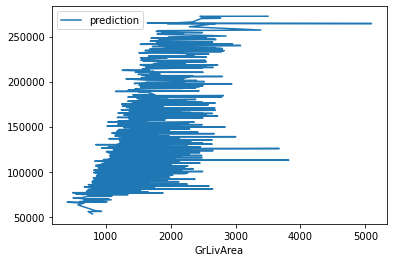

<AxesSubplot:xlabel='GrLivArea'>

In [0]:
rf_predictions.select(['Id','GrLivArea','prediction']).sort(['prediction'],ascending=False).toPandas().plot(x="GrLivArea", y="prediction")

Out[116]:

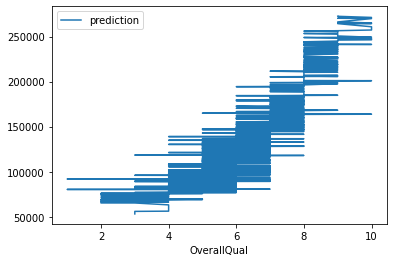

<AxesSubplot:xlabel='OverallQual'>

In [0]:
rf_predictions.select(['Id','OverallQual','prediction']).sort(['prediction'],ascending=False).toPandas().plot(x="OverallQual", y="prediction")

Out[117]:

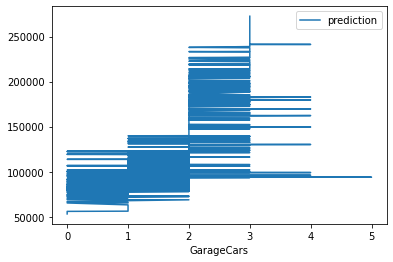

<AxesSubplot:xlabel='GarageCars'>

In [0]:
rf_predictions.select(['Id','GarageCars','prediction']).sort(['prediction'],ascending=False).toPandas().plot(x="GarageCars", y="prediction")

* From the histogram plots we could observe the predictions are more relatively for houses with more OverallQual, GrLivArea and GarageCars

* We can see that OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF ,1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd, Fireplaces, BsmtFinSF1, WoodDeckSF, 2ndFlrSF, OpenPorchSF, HalfBath, LotArea, BsmtFinSF1 are the top influencers of the Sale Price

* The predictions from Random Forest Regression are better than those from Linear Regression. This is because there are 18 important features after feature extraction, which is a large number and more complex. Even though there is a risk of overfitting the data using Random Forest. It is still better than Linear Regression where important features would be missed and underfitting would occur.

#### 22. Model Versioning

* The Models are versioned based on type of model and timestamps when they were created. These are stored of databrick file system hosted on AWS S3 buckets of the databricks stack on AWS.

#### 23. Future Scope

* We want to further explain the model using SHAP library and analyse bias and variance factors in the underlying data

* We want to also create a data versioning to explain the model and concept drifts in the future.